### Forecasting using Extreme Gradient Boosting (XGBoost) Regressor Model

In [1]:
# Import Library
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

#Import dataset
df_price = pd.read_csv('C:/Users/Jan/Desktop/JAN/GRIP-INTERNSHIP/PSEI-Analysis/PSEI(2014-2023).csv')
df_forecast_prophet = pd.read_excel('C:/Users/Jan/Desktop/JAN/GRIP-INTERNSHIP/PSEI-Analysis/df_forecast_prophet.xlsx')
df_forecast_arima = pd.read_excel('C:/Users/Jan/Desktop/JAN/GRIP-INTERNSHIP/PSEI-Analysis/df_forecast_arima.xlsx')


Preprocess Features

In [2]:
#Transform dataset
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_price = df_price.drop(['High', 'Low', 'Adj Close', 'Open', 'Volume'], axis=1)
df_price = df_price.dropna().set_index('Date').sort_values(by='Date')
df_forecast_arima = df_forecast_arima.set_index('Date').rename(columns={'Close': 'ARIMA'})

# For this experiment, I'll populate the null values of ARIMA column by...
df_price['ARIMA'] = df_price.Close.shift(-1) # Shift -1 is also like Lag = 1, based on ARIMA model hyperparameters
df_price['ARIMA'].fillna(df_price['Close'], inplace=True)
df_merged_xgb = pd.concat([df_price, df_forecast_arima])
df_merged_xgb = pd.merge(df_merged_xgb, df_forecast_prophet, on='Date', how='outer').set_index('Date').sort_values(by='Date')
display(df_merged_xgb)

,Close,ARIMA,yhat,yhat_lower,yhat_upper
Date,,,,,
2014-01-02,5984.259766,5947.930176,6005.063694,5654.734536,6324.295683
2014-01-03,5947.930176,5985.810059,6019.358572,5678.615063,6377.840517
2014-01-06,5985.810059,5947.439941,6069.289652,5719.329921,6417.028110
2014-01-07,5947.439941,5986.479980,6085.558766,5758.112489,6427.594568
2014-01-08,5986.479980,5937.509766,6106.765813,5760.711719,6425.892438
...,...,...,...,...,...
2024-05-06,NaN,7074.478350,6109.648197,4174.113305,8005.850510
2024-05-07,NaN,7075.227236,6103.244658,4140.824705,8031.686071
2024-05-08,NaN,7075.971253,6102.751541,4294.808336,8058.391769


In [3]:
df_xgb_train = df_merged_xgb.head(2280)
display(df_xgb_train)

df_xgb_forecast = df_merged_xgb.tail(260)
display(df_xgb_forecast)

,Close,ARIMA,yhat,yhat_lower,yhat_upper
Date,,,,,
2014-01-02,5984.259766,5947.930176,6005.063694,5654.734536,6324.295683
2014-01-03,5947.930176,5985.810059,6019.358572,5678.615063,6377.840517
2014-01-06,5985.810059,5947.439941,6069.289652,5719.329921,6417.028110
2014-01-07,5947.439941,5986.479980,6085.558766,5758.112489,6427.594568
2014-01-08,5986.479980,5937.509766,6106.765813,5760.711719,6425.892438
...,...,...,...,...,...
2023-05-08,6600.740234,6622.609863,6376.806793,6026.357591,6710.436272
2023-05-09,6622.609863,6658.589844,6371.081501,6041.234166,6712.690080
2023-05-10,6658.589844,6675.459961,6371.348861,6018.924832,6729.461728


,Close,ARIMA,yhat,yhat_lower,yhat_upper
Date,,,,,
2023-05-15,NaN,6581.841660,6355.619044,5995.787554,6713.370209
2023-05-16,NaN,6585.793555,6355.098554,6000.288847,6699.220767
2023-05-17,NaN,6589.719755,6360.768287,6005.890895,6685.831840
2023-05-18,NaN,6593.620427,6363.370239,6028.589258,6701.063831
2023-05-19,NaN,6597.495739,6362.791237,6005.904091,6705.808828
...,...,...,...,...,...
2024-05-06,NaN,7074.478350,6109.648197,4174.113305,8005.850510
2024-05-07,NaN,7075.227236,6103.244658,4140.824705,8031.686071
2024-05-08,NaN,7075.971253,6102.751541,4294.808336,8058.391769


Select features to train

In [4]:
train_data = df_xgb_train.iloc[:int(.80*len(df_price)), :]
test_data = df_xgb_train.iloc[int(.80*len(df_price)):, :]
print(train_data.shape , test_data.shape)

features = ['yhat','yhat_lower','yhat_upper', 'ARIMA']
target = 'Close'

X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
display(X_test)

(1824, 5) (456, 5)
(1824, 4) (1824,) (456, 4) (456,)


,yhat,yhat_lower,yhat_upper,ARIMA
Date,,,,
2021-07-07,6927.097225,6607.551169,7293.607346,6924.990234
2021-07-08,6929.741169,6587.513160,7259.802968,6834.919922
2021-07-09,6928.561314,6573.067261,7292.550915,6913.870117
2021-07-12,6932.154506,6596.671106,7271.134983,6795.129883
2021-07-13,6933.238233,6603.917240,7293.715215,6835.410156
...,...,...,...,...
2023-05-08,6376.806793,6026.357591,6710.436272,6622.609863
2023-05-09,6371.081501,6041.234166,6712.690080,6658.589844
2023-05-10,6371.348861,6018.924832,6729.461728,6675.459961


#### Build and train model

In [5]:
# Build and train model
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000, early_stopping_rounds = 50, objective='reg:linear', max_depth=3, learning_rate=0.01)
model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=50)

[06:27:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6699.91869
[50]	validation_0-rmse:4046.04052
[100]	validation_0-rmse:2445.23700
[150]	validation_0-rmse:1478.02030
[200]	validation_0-rmse:893.94190
[250]	validation_0-rmse:542.49539
[300]	validation_0-rmse:333.48065
[350]	validation_0-rmse:211.32083
[400]	validation_0-rmse:143.69925
[450]	validation_0-rmse:109.29029
[500]	validation_0-rmse:93.96800
[550]	validation_0-rmse:88.00096
[600]	validation_0-rmse:85.93079
[650]	validation_0-rmse:85.22838
[700]	validation_0-rmse:85.06285
[750]	validation_0-rmse:85.07733
[759]	validation_0-rmse:85.10802


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

Accuracy: 94.98%


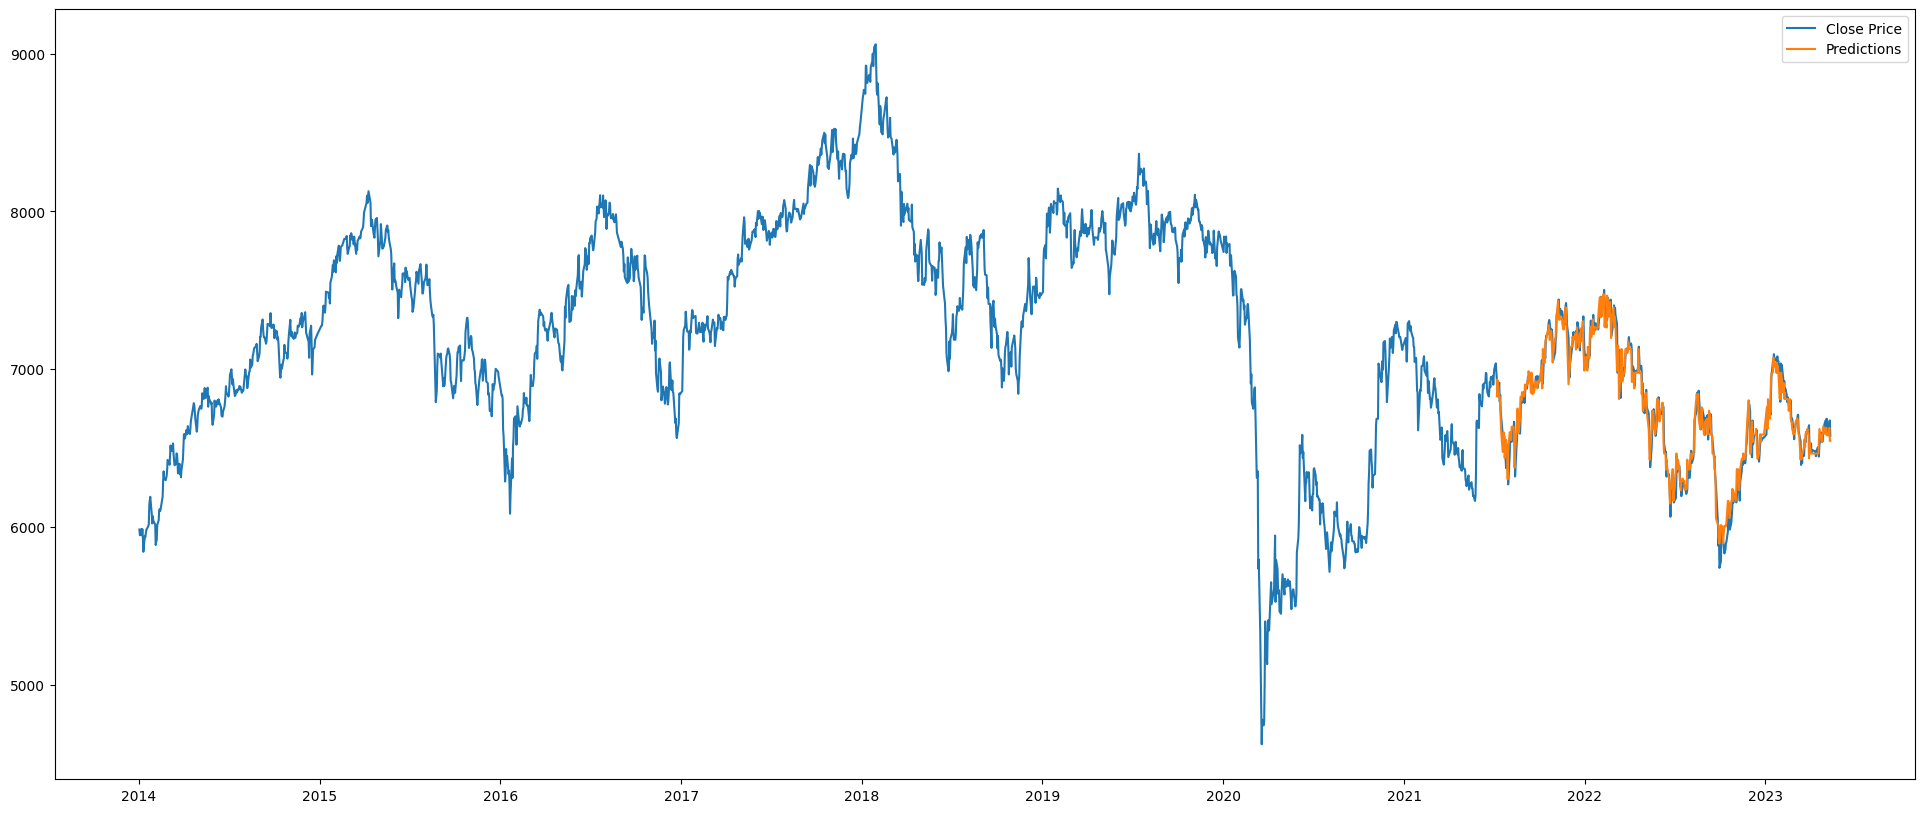

In [6]:
# Predict the unseen data (test data)
predictions = model.predict(X_test)
# Evaluate model accuracy
accuracy = model.score(X_test, y_test) * 100
print('Accuracy: {:.2f}%'.format(accuracy))

# Plot actual vs predicted unseen data
plt.figure(figsize=(24, 10))
plt.plot(df_xgb_train.index, df_xgb_train['Close'], label = 'Close Price')
plt.plot(X_test.index, predictions, label = 'Predictions' )
plt.legend()
plt.show()

In [16]:
df_xgb_forecast = df_xgb_forecast.assign(XGB_forecast ='')
df_xgb_forecast['XGB_forecast'] = model.predict(df_xgb_forecast[features])
display(df_xgb_forecast)

,Close,ARIMA,yhat,yhat_lower,yhat_upper,XGB_forecast
Date,,,,,,
2023-05-15,NaN,6581.841660,6355.619044,5995.787554,6713.370209,6545.489746
2023-05-16,NaN,6585.793555,6355.098554,6000.288847,6699.220767,6545.739258
2023-05-17,NaN,6589.719755,6360.768287,6005.890895,6685.831840,6545.739258
2023-05-18,NaN,6593.620427,6363.370239,6028.589258,6701.063831,6581.585449
2023-05-19,NaN,6597.495739,6362.791237,6005.904091,6705.808828,6581.335938
...,...,...,...,...,...,...
2024-05-06,NaN,7074.478350,6109.648197,4174.113305,8005.850510,6846.677734
2024-05-07,NaN,7075.227236,6103.244658,4140.824705,8031.686071,6846.677734
2024-05-08,NaN,7075.971253,6102.751541,4294.808336,8058.391769,6846.677734


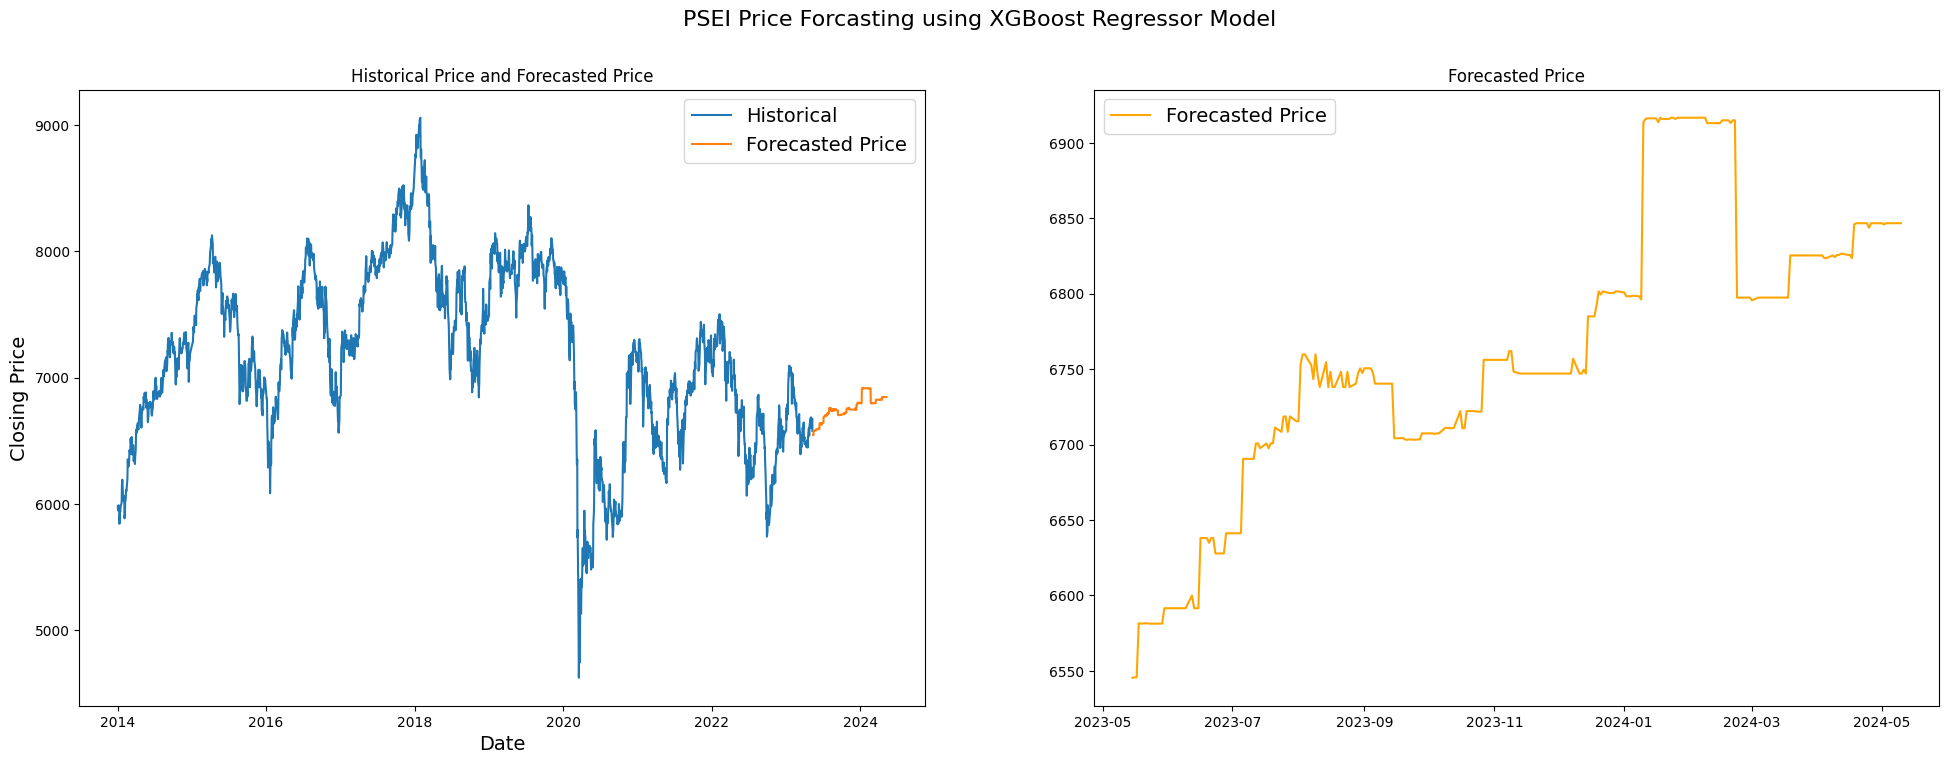

In [17]:
# Visualize results
plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(df_price.index, df_price['Close'], label = 'Historical')
plt.plot(df_xgb_forecast.index, df_xgb_forecast['XGB_forecast'], label = 'Forecasted Price')
plt.title('Historical Price and Forecasted Price')
plt.legend(fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)
plt.subplot(1, 2, 2)
plt.plot(df_xgb_forecast.index, df_xgb_forecast['XGB_forecast'], color='orange', label = 'Forecasted Price')
plt.title('Forecasted Price')
plt.legend(fontsize=14)
plt.suptitle('PSEI Price Forcasting using XGBoost Regressor Model', fontsize=16)
plt.show()

## Compilation in Power BI

!insert

In [10]:
# df_xgb_forecast.to_excel('df_forecast_xgb.xlsx')